In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np 

In [3]:
tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

--2021-01-02 21:46:39--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.20.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2021-01-02 21:46:39 (95.4 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [26]:
tokenizer.index_word[0] = "<>"
for seq in input_sequences[:5]:
    print(seq.shape)
    print(repr(''.join((tokenizer.index_word[x] for x in seq))))

(11,)
'<><><><><><><><><>fromfairest'
(11,)
'<><><><><><><><>fromfairestcreatures'
(11,)
'<><><><><><><>fromfairestcreatureswe'
(11,)
'<><><><><><>fromfairestcreatureswedesire'
(11,)
'<><><><><>fromfairestcreatureswedesireincrease'


In [38]:
# Length of the vocabulary in chars
vocab_size = len(tokenizer.word_index) + 1

# The embedding dimension
embedding_dim = 256

# Number of RNN units
lstm_units = 1024

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_sequence_len-1))
model.add(LSTM(lstm_units, return_sequences=True,))
model.add(Dropout(0.2))
model.add(LSTM(lstm_units))
model.add(Dense(512, 
                kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), 
                bias_regularizer=regularizers.l2(1e-4),
                activity_regularizer=regularizers.l2(1e-5)))
model.add(Dense(vocab_size, activation='softmax'))
# Pick an optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 10, 256)           822016    
_________________________________________________________________
lstm_10 (LSTM)               (None, 10, 1024)          5246976   
_________________________________________________________________
dropout_5 (Dropout)          (None, 10, 1024)          0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 1024)              8392704   
_________________________________________________________________
dense_8 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_9 (Dense)              (None, 3211)              1647243   
Total params: 16,633,739
Trainable params: 16,633,739
Non-trainable params: 0
__________________________________________

In [39]:
history = model.fit(predictors, label, epochs=100, verbose=1)

Epoch 1/100
484/484 [==============================] - 13s 22ms/step - loss: 7.1559 - accuracy: 0.0190
Epoch 2/100
484/484 [==============================] - 10s 21ms/step - loss: 6.5207 - accuracy: 0.0234
Epoch 3/100
484/484 [==============================] - 10s 21ms/step - loss: 6.4089 - accuracy: 0.0294
Epoch 4/100
484/484 [==============================] - 10s 22ms/step - loss: 6.2293 - accuracy: 0.0379
Epoch 5/100
484/484 [==============================] - 10s 22ms/step - loss: 6.1162 - accuracy: 0.0384
Epoch 6/100
484/484 [==============================] - 10s 22ms/step - loss: 5.9521 - accuracy: 0.0499
Epoch 7/100
484/484 [==============================] - 10s 22ms/step - loss: 5.8297 - accuracy: 0.0570
Epoch 8/100
484/484 [==============================] - 11s 22ms/step - loss: 5.7145 - accuracy: 0.0571
Epoch 9/100
484/484 [==============================] - 11s 22ms/step - loss: 5.6295 - accuracy: 0.0611
Epoch 10/100
484/484 [==============================] - 11s 22ms/step - l

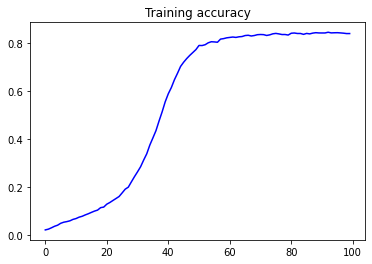

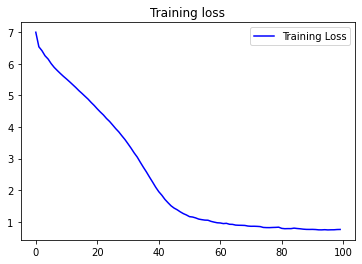

In [40]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [41]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Help me Obi Wan Kenobi, you're my only hope of battering days are short aside 'will' ' ' of ' ' shows ' of me nor it nor thy sake go treasure fullness his due lies buried face ' alter'd ' in your ' is but ' shows call the world ' thee nor i am old ' can ' of heaven's gate bring ' to ' are ' to ' thee is the lays ' eyed are one ' shows not his ' lies shows for ' did go ' can ' to hope of single one ' ' again ' may ' have ' nor dress his
